In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import csv
import copy

from math import log

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from maskingPackage import weight_perc

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

# device = "cpu"

print(device)

cuda:0


In [3]:
k_folds = 5
num_of_epoch = 100
output_size = 1
binary_classification = True
torch.manual_seed(42)
np.random.seed(42)

In [4]:
hidden_Layer_1 = 256
hidden_Layer_2 = 128
hidden_Layer_3 = 64

In [5]:
def normalize_dataset(train_df, test_df, y_column_name):
    y_train = train_df[y_column_name]
    X_train = train_df.drop([y_column_name], axis=1)

    y_test = test_df[y_column_name]
    X_test = test_df.drop([y_column_name], axis=1)

    min_max_scaler = preprocessing.MinMaxScaler()
    scale = min_max_scaler.fit(X_train)
    
    x_train_transformed = scale.transform(X_train)
    x_test_transformed = scale.transform(X_test)

    train_df_standardized = pd.DataFrame(x_train_transformed, columns = X_train.columns)
    test_df_standardized = pd.DataFrame(x_test_transformed, columns = X_test.columns)

    train_df = pd.concat([train_df_standardized.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    test_df = pd.concat([test_df_standardized.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

    return train_df, test_df

In [6]:
def standardize_dataset(train_df, test_df, y_column_name):

    y_train = train_df[y_column_name]
    X_train = train_df.drop([y_column_name], axis=1)

    y_test = test_df[y_column_name]
    X_test = test_df.drop([y_column_name], axis=1)

    # standardize
    sc = StandardScaler()
    scale = sc.fit(X_train)
    
    x_train_transformed = scale.transform(X_train)
    x_test_transformed = scale.transform(X_test)

    train_df_standardized = pd.DataFrame(x_train_transformed, columns = X_train.columns)
    
    test_df_standardized = pd.DataFrame(x_test_transformed, columns = X_test.columns)

    train_df = pd.concat([train_df_standardized.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    test_df = pd.concat([test_df_standardized.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

    return train_df, test_df

In [7]:
#Read files
def file_reader(file_path):
    '''Input = file path (str)
       Output = numpy array of items in files
    '''
    
    data = []
    with open(file_path) as f:
        reader = csv.reader(f, delimiter='\n')
        for row in reader:
            for x in row:
                x=x.split(' ')
                example = []
                for item in x:
                    if item:
                        item = int(item) #convert to int
                        example.append(item)
                data.append(example)
        data = np.asarray(data)
    return data

In [8]:
## arcene
dbName = 'arcene'

arcene_train_X = file_reader('hd-datasets/ARCENE/arcene_train.data')
arcene_test_X = file_reader('hd-datasets/ARCENE/arcene_valid.data')

arcene_train_y = file_reader('hd-datasets/ARCENE/arcene_train.labels')
arcene_train_y = np.ravel(arcene_train_y)
arcene_test_y = file_reader('hd-datasets/ARCENE/arcene_valid.labels')
arcene_test_y = np.ravel(arcene_test_y)

arcene_train = np.column_stack( (arcene_train_X,arcene_train_y) )
arcene_test = np.column_stack( (arcene_test_X,arcene_test_y) )
arcene = np.row_stack( (arcene_train,arcene_test) )

data_df = pd.DataFrame.from_records(arcene)
y_column_name = 10000

le = LabelEncoder()
data_df[y_column_name] = le.fit_transform(data_df[y_column_name])

In [9]:
data_df

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,0,71,0,95,0,538,404,20,0,0,...,570,86,0,36,0,80,0,0,524,1
1,0,41,82,165,60,554,379,0,71,0,...,605,69,7,473,0,57,0,284,423,0
2,0,0,1,40,0,451,402,0,0,0,...,593,28,0,24,0,90,0,34,508,1
3,0,56,44,275,14,511,470,0,0,0,...,600,0,26,86,0,102,0,0,469,1
4,105,0,141,348,0,268,329,0,0,1,...,0,0,0,0,190,301,0,0,354,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,24,73,0,436,92,400,0,0,139,261,...,540,0,86,130,365,58,17,3,37,0
196,11,58,50,332,109,393,122,0,75,134,...,355,156,77,26,277,265,0,36,261,0
197,93,32,137,319,0,264,231,21,0,0,...,9,0,0,0,244,309,0,276,312,1
198,119,12,198,339,0,289,410,0,0,4,...,0,37,0,0,256,402,0,0,350,1


In [10]:
def average_multiple_lists(multiple_lists):
    data = np.array(multiple_lists)
    return np.average(data, axis=0), np.std(data,axis=0)

In [11]:
# basic auto encoder with one layer
class Autoencoder(nn.Module):

    def __init__(self,input_size=24,output_size=12):
        super().__init__()       
        self.encoder = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.ReLU(),
            # nn.Dropout(0.20)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(output_size, input_size),
            nn.ReLU(),
            # nn.Dropout(0.20)
        )
        
    def forward(self, x):
        self.encoded = self.encoder(x)
        decoded = self.decoder(self.encoded)
        return decoded

In [12]:
# basic auto encoder with three layers
class Basic_Autoencoder(nn.Module):

    def __init__(self, input_size, output_size = 1):

        hidden_L_1 = hidden_Layer_1
        hidden_L_2 = hidden_Layer_2
        hidden_L_3 = hidden_Layer_3
        

        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_L_1),
            nn.ReLU(),
            # nn.Dropout(0.20),
            nn.Linear(hidden_L_1, hidden_L_2),
            nn.ReLU(),
            # nn.Dropout(0.20),
            nn.Linear(hidden_L_2, hidden_L_3),
            nn.ReLU(),
            # nn.Dropout(0.20)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_L_3, hidden_L_2),
            nn.ReLU(),
            # nn.Dropout(0.20),
            nn.Linear(hidden_L_2, hidden_L_1),
            nn.ReLU(),
            # nn.Dropout(0.20),
            nn.Linear(hidden_L_1, input_size),
            nn.ReLU(),
            # nn.Dropout(0.20)
        )

    # pre training
    def forward(self, x):
        self.encoded = self.encoder(x)
        decoded = self.decoder(self.encoded)
        return decoded

class Basic_Autoencoder_Classifier(nn.Module):
    def __init__(self, input_size, output_size, encoder):
        
        hidden_L_3 = hidden_Layer_3
        
        super().__init__()
        self.encoder = encoder
        self.classification_layer = nn.Linear(hidden_L_3, output_size)
        self.classifier = nn.Sequential(self.encoder, self.classification_layer)
        self.activation = nn.Softmax(dim=1)
        if binary_classification:
            self.activation = nn.Sigmoid()

    # fine-tuning
    def forward(self, x):
        intermediate = self.classifier(x)
        if binary_classification:
            return self.activation(intermediate)
        else:
            # no activation function is used for multiclass classification
            # cross entrophy loss automatically applies softmax in pytorch
            return intermediate

In [15]:
class Stacked_Autoencoder(nn.Module):

    def __init__(self,input_size, output_size=1):
        super().__init__()

        hidden_L_1 = hidden_Layer_1
        hidden_L_2 = hidden_Layer_2
        hidden_L_3 = hidden_Layer_3     

        self.ae1 = Autoencoder(input_size=input_size, output_size=hidden_L_1)
        self.ae2 = Autoencoder(input_size=hidden_L_1, output_size=hidden_L_2)
        self.ae3 = Autoencoder(input_size=hidden_L_2, output_size=hidden_L_3)

        # add the 3 encoders and decoders in a sequential
        self.encoder = nn.Sequential(self.ae1.encoder, self.ae2.encoder, self.ae3.encoder)
        self.decoder = nn.Sequential(self.ae3.decoder, self.ae2.decoder, self.ae1.decoder)

    # pre-training
    def forward(self, x):
        self.encoded = self.encoder(x)
        decoded = self.decoder(self.encoded)
        return decoded

class Stacked_Autoencoder_Classifier(nn.Module):
    def __init__(self, input_size, output_size, encoder):
        hidden_L_3 = hidden_Layer_3
        
        super().__init__()
        self.encoder = encoder
        self.classification_layer = nn.Linear(hidden_L_3, output_size)
        self.classifier = nn.Sequential(self.encoder, self.classification_layer)
        self.activation = nn.Softmax(dim=1)
        if binary_classification:
            self.activation = nn.Sigmoid()

    # fine-tuning
    def forward(self, x):
        intermediate = self.classifier(x)
        if binary_classification:
            return self.activation(intermediate)
        else:
            # no activation function is used for multiclass classification
            # cross entrophy loss automatically applies softmax in pytorch
            return intermediate

    

In [16]:
def weight_perturbation(model, epoch, perc_weight, limit_counter):
    every = 30
    mtype='Low'

    state_dict = model.state_dict()
    Wold_dict = {}

    if epoch % every == 0 and epoch >= 10 and limit_counter < 3: 
        for name, param in state_dict.items():

            # ignore biases
            if not "weight" in name:
                continue


            W =  param.cpu().numpy()
            if name not in Wold_dict:
                Wold = np.ones(W.shape)
            else:
                Wold = Wold_dict[name]

            Wold, perc = weight_perc(Wold,W,mtype)
            Wold_dict[name] = Wold
            perc_weight.append(perc)
            wm = np.multiply(Wold,W)
            wm = torch.from_numpy(wm)
            state_dict[name].copy_(wm)
        limit_counter = limit_counter+1
        # just making sure the weights are updated, can be commented out
        model.load_state_dict(state_dict)

        print('The average of weights perturbation: ',sum(perc_weight)/len(perc_weight), '%')

    return perc_weight, Wold_dict

In [ ]:
def get_stacked_combined_mask( model, Wold_dict_1, Wold_dict_2, Wold_dict_3):
    state_dict = model.state_dict()
    Wold_dict = {}

    for name, param in state_dict.items():

        # ignore biases
        if not "weight" in name:
            continue


        W =  param.cpu().numpy()
        Wold = np.ones(W.shape)
        if 'ae1' in name:
            x = name
            Wold = Wold_dict_1[name]
        if 'ae2' in name:
            Wold = Wold_dict_2[name]
        if 'ae3' in name:
            Wold = Wold_dict_3[name]

        Wold_dict[name] = Wold
        wm = np.multiply(Wold,W)
        wm = torch.from_numpy(wm)
        state_dict[name].copy_(wm)

In [ ]:
def finetune_weight_masking(model, Wold_dict):

    state_dict = model.state_dict()
    

    for name, param in state_dict.items():

        # ignore biases
        if not "weight" in name:
            continue


        W =  param.cpu().numpy()
        if name not in Wold_dict:
            Wold = np.ones(W.shape)
        else:
            Wold = Wold_dict[name]

        Wold_dict[name] = Wold
        wm = np.multiply(Wold,W)
        wm = torch.from_numpy(wm)
        state_dict[name].copy_(wm)

    # print('Achieved model compression: ',sum(perc_weight)/len(perc_weight), '%')

    return model

In [ ]:
model_compressions = []

def calculate_model_compression(model):
    perc_weight = []
    state_dict = model.state_dict()

    for name, param in state_dict.items():

        # ignore biases and the decoder weights
        if not "weight" in name or "decoder" in name:
            continue

        W =  param.cpu().numpy()
        cnt_zero = len(np.ravel(W))-np.count_nonzero(W)
        perc = (( cnt_zero)*100)/len(np.ravel(W))
        perc_weight.append(perc)
        param.requires_grad = False

    model_compressions.append(sum(perc_weight)/len(perc_weight))
    return model


In [17]:
def model_pretraining(model, dataset, num_of_epoch):

    # to run on gpu
    model = model.to(device)

    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=64,
                                            shuffle=True)

    # latent is needed for stacked autoencoder pre-training
    latent = torch.tensor([])
    latent = latent.to(device)
    
    training_lle = []
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    perc_weight = []
    limit_counter = 0
    minimum_loss = None
    best_epoch = 0

    for epoch in range(num_of_epoch):
        for train in data_loader:
            model = model.train()
            optimizer.zero_grad()
            train = train.float()
            decoded = model(train)
            loss = criterion(decoded, train)
            loss.backward()
            optimizer.step()
            if(epoch == num_of_epoch - 1):
                latent = torch.cat((latent, model.encoded), 0)
            
            # save the model with minimum loss
            if minimum_loss is None or minimum_loss > loss.item():
                minimum_loss = loss.item()
                best_epoch = epoch
                torch.save(model.state_dict(), dbName+'pretrained_best_model.pt')

        training_lle.append(loss.item())
    
        # weight perturbation happens here
        perc_weight, Wold_dict = weight_perturbation(model, epoch+1, perc_weight, limit_counter)

    # load and return the model with minimum loss at the end
    print("best_epoch = " + str(best_epoch))
    model.load_state_dict(torch.load(dbName+'pretrained_best_model.pt'))
    model = calculate_model_compression(model)
    
    return model, training_lle, latent, Wold_dict

In [18]:
# includes weight perturbation
def model_finetuning(model, train_tensor, num_of_epoch, train_x, train_y, test_x, test_y, Wold_dict):

    model = model.to(device)

    finetuning_loss = []
    train_accuracy_scores = []
    test_accuracy_scores = []

    data_loader = torch.utils.data.DataLoader(dataset=train_tensor,
                                        batch_size=64,
                                        shuffle=True)

    criterion = nn.CrossEntropyLoss()
    if binary_classification:
        criterion = nn.BCELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    perc_weight = []

    limit_counter = 0
    for epoch in range(num_of_epoch):
        model = model.train()
        for train,target in data_loader:
            optimizer.zero_grad()

            # to make sure all variables are float type
            train = train.float()
            target = target.float()

            prediction = model(train)
            # target = target.unsqueeze(1)
            classification_loss = criterion(prediction, target.unsqueeze(1))
            classification_loss.backward()
            optimizer.step()

        finetune_weight_masking(model, Wold_dict)

        # weight perturbation happens here
        # perc_weight = weight_perturbation(model, epoch, perc_weight, limit_counter)
            
        model = finetuning_loss.append(classification_loss.item())

        # train accuracy after each epoch
        model = model.eval()
        prediction_train = model(train_x)
        prediction_train = prediction_train.flatten()
        train_accuracy = accuracy_score(train_y.cpu().detach().numpy(),np.round(prediction_train.cpu().detach().numpy()))
        train_accuracy_scores.append(train_accuracy)

        # test accuracy after each epoch
        prediction_test = model(test_x)
        prediction_test = prediction_test.flatten()
        test_accuracy = accuracy_score(test_y.cpu().detach().numpy(),np.round(prediction_test.cpu().detach().numpy()))
        test_accuracy_scores.append(test_accuracy)

        # calculate generalizability index at 100th epoch
        if epoch == 99:
            train_loss = criterion(prediction_train, train_y)
            test_loss = criterion(prediction_test, test_y)
            g_index = (train_loss.item()/train_x.shape[1])/(test_loss.item()/test_x.shape[1])
            print(g_index)
    
    return model, finetuning_loss, train_accuracy_scores ,test_accuracy_scores, prediction

In [19]:
def convert_df_to_tensor(df):
    y_train = df[y_column_name]
    X_train = df.drop([y_column_name], axis=1)
    y_tensor = torch.tensor(y_train.values)
    x_tensor = torch.tensor(X_train.values)
    x_tensor = x_tensor.to(device)
    y_tensor = y_tensor.to(device)

    # commented out normalization here because data is standardized
    # x_tensor_norm = torch.nn.functional.normalize(x_tensor, p=2.0, dim=1, eps=1e-12, out=None)
    
    dataset_tensor = data_utils.TensorDataset(x_tensor, y_tensor)
    return x_tensor, y_tensor, dataset_tensor

In [20]:
def ae_training(model_name, dataset, num_of_epoch, k_folds):

    kfold = KFold(n_splits = k_folds, random_state= 42, shuffle = True)

    
    pretraining_loss_fold = []
    pretraining_loss_1_fold = []
    pretraining_loss_2_fold = []
    pretraining_loss_3_fold = []
    finetuning_loss_fold = []
    train_accuracy_fold = []
    test_accuracy_fold = []
    classification_accuracy_fold = []
    
    fold_counter = 0
    # run k fold in loop
    for train, test in list(kfold.split(dataset)):

        fold_counter+=1

        # divide the data for train and test
        train_df = dataset.iloc[train]
        test_df =  dataset.iloc[test]

        train_df, test_df = standardize_dataset(train_df, test_df, y_column_name)
        # train_df= normalize_dataset(train_df, y_column_name)
        # test_df= normalize_dataset(test_df, y_column_name)

        # convert dataframe into train and test tensor
        train_x, train_y, train_tensor = convert_df_to_tensor(train_df)
        test_x, test_y, test_tensor = convert_df_to_tensor(test_df)

        x_dim = train_x.shape[1]
        
        model = None
        if model_name == "basic":                                     
            model = Basic_Autoencoder(input_size=x_dim)
            
            # pretraining done here
            model, training_lle, latent, Wold_dict = model_pretraining(model, train_x.float(), num_of_epoch)

            # copy the trained weights and biases when classifier is added to model
            # deep copy is recommended when copying weights and biases from a model
            encoder_sd = copy.deepcopy(model.encoder.state_dict())
            model = Basic_Autoencoder_Classifier(x_dim, output_size, model.encoder)
            model.encoder.load_state_dict(encoder_sd)

            # finetuning done here
            model, finetuning_loss, train_accuracy, test_accuracy, prediction = model_finetuning(model, train_tensor, num_of_epoch, train_x.float(), train_y.float(), test_x.float(), test_y.float(), Wold_dict)

            pretraining_loss_fold.append(training_lle)
            finetuning_loss_fold.append(finetuning_loss)
            train_accuracy_fold.append(train_accuracy)
            test_accuracy_fold.append(test_accuracy)

        elif model_name == "stacked":
            model = Stacked_Autoencoder(input_size=x_dim)                                         

            model.ae1, training_lle_1, latent_1, Wold_dict_1 = model_pretraining(model.ae1, train_x.float(), num_of_epoch)
            model.ae2, training_lle_2, latent_2, Wold_dict_2 = model_pretraining(model.ae2, latent_1.detach(), num_of_epoch)
            model.ae3, training_lle_3, latent_3, Wold_dict_3 = model_pretraining(model.ae3, latent_2.detach(), num_of_epoch)

            Wold_dict = get_stacked_combined_mask(model, Wold_dict_1, Wold_dict_2, Wold_dict_3)


            encoder_sd = copy.deepcopy(model.encoder.state_dict())
            model = Stacked_Autoencoder_Classifier(x_dim, output_size, model.encoder)
            model.encoder.load_state_dict(encoder_sd)                                          
                    
            model, finetuning_loss, train_accuracy, test_accuracy, prediction = model_finetuning(model, train_tensor, num_of_epoch, train_x.float(), train_y.float(), test_x.float(), test_y.float(), Wold_dict)

            pretraining_loss_1_fold.append(training_lle_1)
            pretraining_loss_2_fold.append(training_lle_2)
            pretraining_loss_3_fold.append(training_lle_3)
            finetuning_loss_fold.append(finetuning_loss)
            train_accuracy_fold.append(train_accuracy)
            test_accuracy_fold.append(test_accuracy)

            latent = [latent_1, latent_2, latent_3]

        # calculate final test accuracy, confusion matrix etc
        test_x = test_x.float()
        prediction_tensor = model(test_x)
        classification_accuracy_fold.append(accuracy_score(test_y.cpu().detach().numpy(),np.round(prediction_tensor.cpu().detach().numpy().flatten())))
        plt.rcParams.update({'font.size': 13})
        confusion_plt = ConfusionMatrixDisplay.from_predictions(test_y.cpu().detach().numpy(), np.round_(prediction_tensor.cpu().detach().numpy().flatten()),cmap=plt.cm.Greens)
        plt.savefig(dbName+"_"+model_name+"_"+str(fold_counter))
        report = classification_report(test_y.cpu().detach().numpy(),np.round_(prediction_tensor.cpu().detach().numpy().flatten()), output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        report_df.to_csv(dbName+"_"+model_name+"_"+str(fold_counter), index= True)

        # take average of fold losses
        if model_name == "stacked":
            training_lle_1 = average_multiple_lists(pretraining_loss_1_fold)
            training_lle_2 = average_multiple_lists(pretraining_loss_2_fold)
            training_lle_3 = average_multiple_lists(pretraining_loss_3_fold)
            training_lle = [training_lle_1, training_lle_2, training_lle_3]
        else:
            training_lle = average_multiple_lists(pretraining_loss_fold)
            
        finetuning_loss = average_multiple_lists(finetuning_loss_fold)
        train_accuracy_curve = average_multiple_lists(train_accuracy_fold)
        test_accuracy_curve = average_multiple_lists(test_accuracy_fold)

    classification_accuracy_mean = np.round(statistics.mean(classification_accuracy_fold),4)
    classification_accuracy_std = np.round(statistics.pstdev(classification_accuracy_fold),4)
    print("test accuracy:",classification_accuracy_mean," (",classification_accuracy_std,")")
    
    return training_lle, finetuning_loss, train_accuracy_curve, test_accuracy_curve, latent, classification_accuracy_mean

In [21]:
def shaded_plot(pair, label, x_label, y_label, filename):
    mean = pair[0]
    std = pair[1]
    plt.figure(figsize=(9, 6))
    x = np.arange(len(mean))
    plt.plot(x, mean, label=label)
    plt.fill_between(x, mean - std, mean + std, alpha=0.2)
    plt.legend(prop={'size': 13})
    plt.xlabel(x_label,fontsize=13)
    plt.ylabel(y_label,fontsize=13)
    plt.savefig(filename)
    plt.show()


def shaded_plot_multiple(pairs, labels, x_label, y_label, filename):
    
    plt.figure(figsize=(9, 6))

    for pair, label in zip(pairs, labels):
        mean = pair[0]
        std = pair[1]
        x = np.arange(len(mean))
        plt.plot(x, mean, label=label)
        plt.fill_between(x, mean - std, mean + std, alpha=0.2)
    
    plt.legend(prop={'size': 13})
    plt.xlabel(x_label,fontsize=13)
    plt.ylabel(y_label,fontsize=13)
    plt.savefig(filename)
    plt.show()

generated/preperturb/arcene/
The average of weights perturbation:  12.376767578125 %
The average of weights perturbation:  14.0552001953125 %
The average of weights perturbation:  15.501346028645834 %
best_epoch = 72
9.982408834530426e-07
The average of weights perturbation:  12.584034830729166 %
The average of weights perturbation:  14.257517903645834 %
The average of weights perturbation:  15.860706380208335 %
best_epoch = 95
1.3160803610791493e-06
The average of weights perturbation:  12.328792317708334 %
The average of weights perturbation:  14.32879150390625 %
The average of weights perturbation:  15.783096245659724 %
best_epoch = 80
1.4898187513538668e-07
The average of weights perturbation:  12.222330729166666 %
The average of weights perturbation:  14.0307666015625 %
The average of weights perturbation:  15.43140625 %
best_epoch = 80
3.7738766920218515e-06
The average of weights perturbation:  12.65259765625 %
The average of weights perturbation:  14.114514973958334 %
The avera

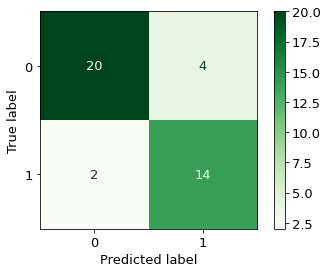

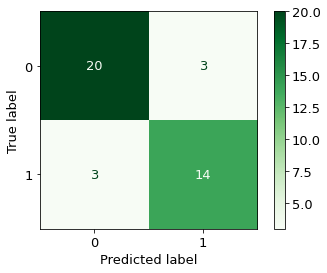

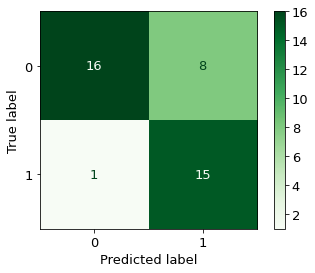

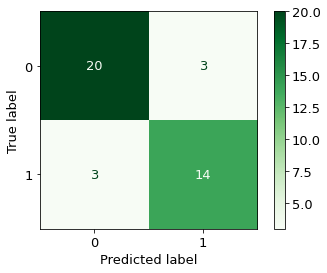

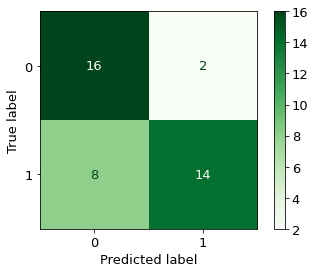

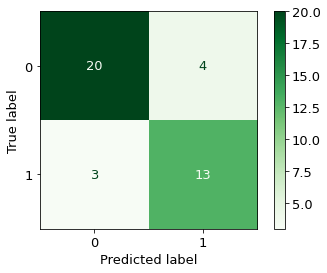

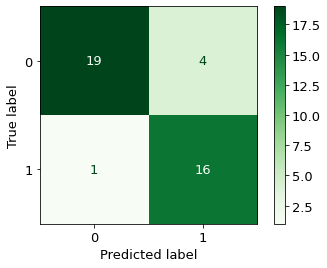

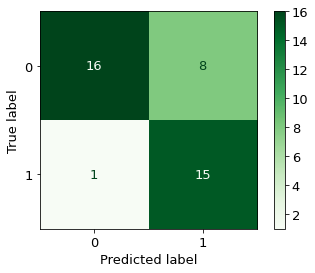

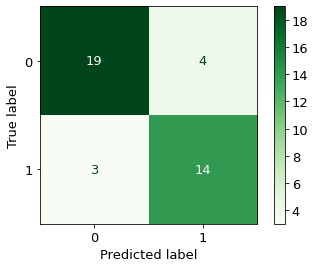

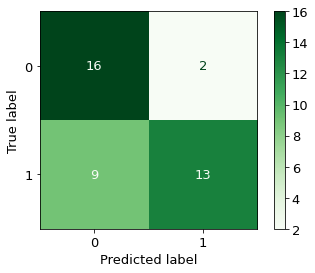

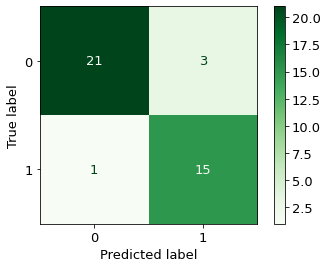

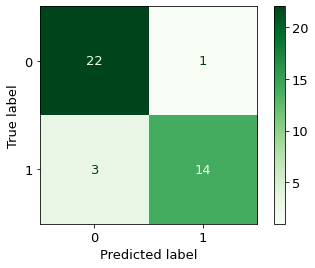

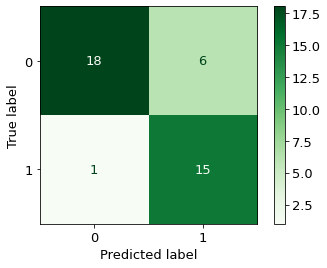

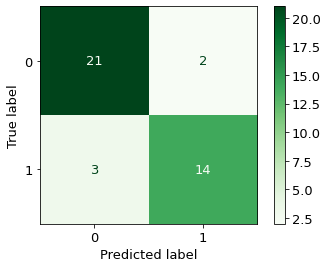

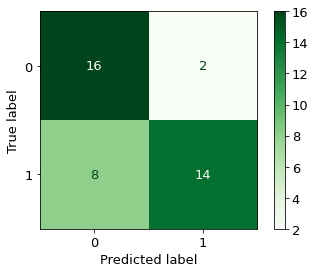

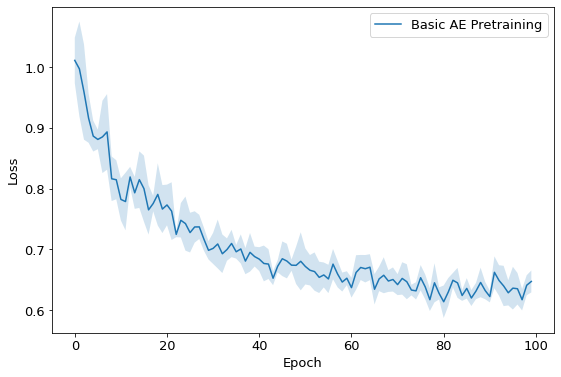

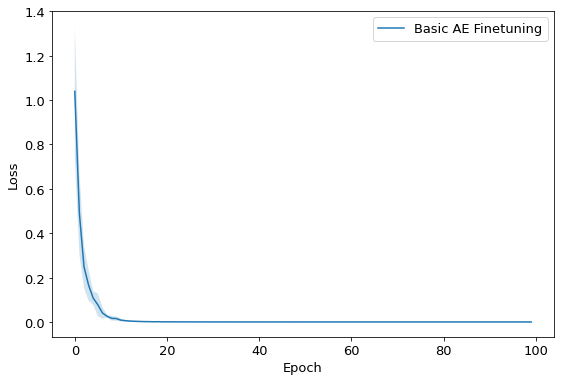

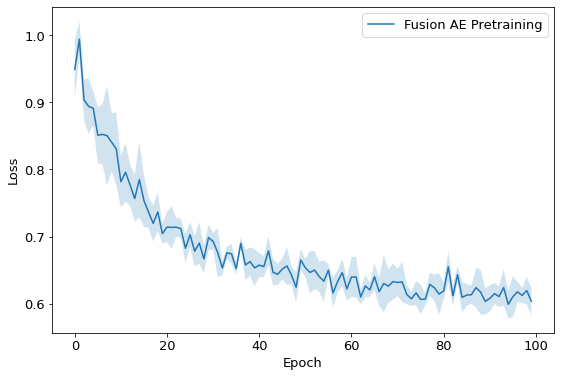

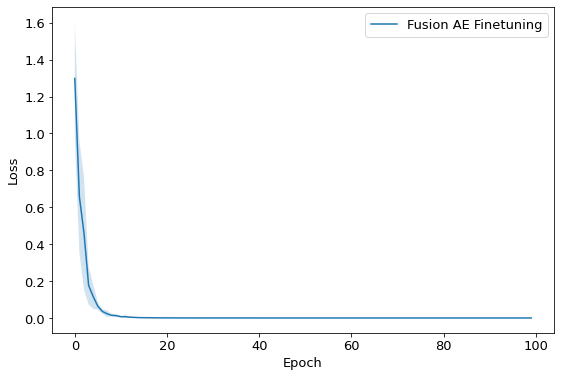

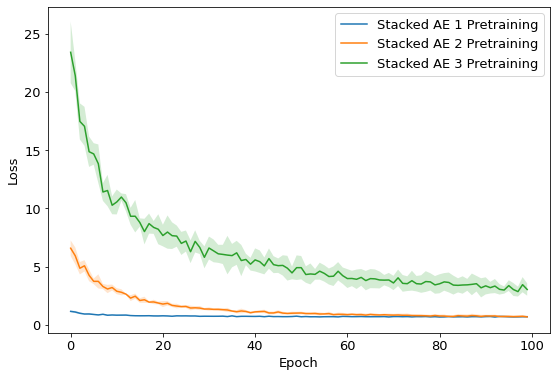

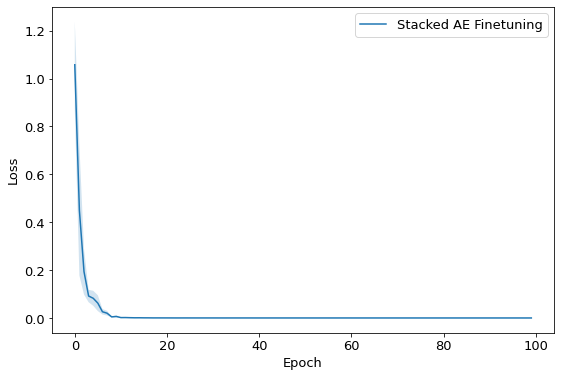

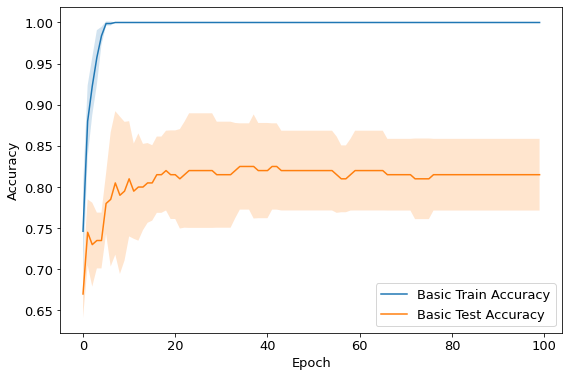

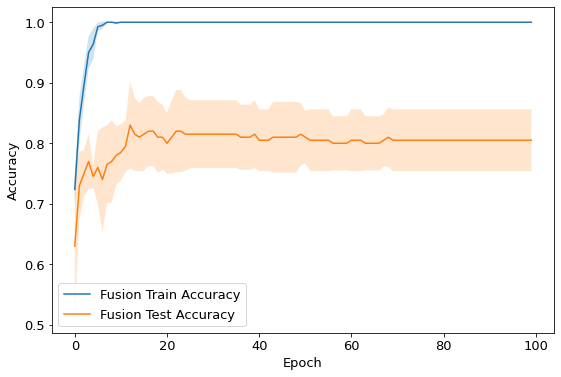

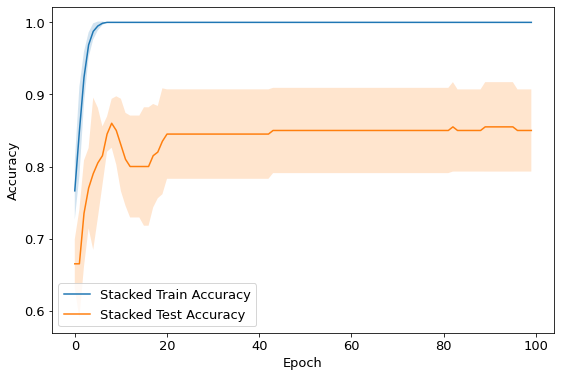

In [22]:
import pickle
dbName = "generated/preperturb/"+dbName +"/"
print(dbName)

info = []


#training basic AE
BLL_Error, BFT_Error, basic_train_accuracy, basic_test_accuracy, basic_latent, basic_accuracy = ae_training('basic',data_df, num_of_epoch, k_folds)
print('Maximum MSELoss of training Basic: ',max(BLL_Error[0]))
print('Maximum BCELoss of finetuning: ',max(BFT_Error[0]))
# print('Mean accuracy: ', basic_accuracy)  
info.append('Maximum MSELoss of Basic AE: ' + str(max(BLL_Error[0])) + '\n')
pd.DataFrame(basic_latent.cpu().detach().numpy()).to_csv(dbName + '_basic_latent'+ '.csv')
with open(dbName+'basic_pretrain.pkl', 'wb') as file:
    pickle.dump(BLL_Error, file)
with open(dbName+'basic_finetune.pkl', 'wb') as file:
    pickle.dump(BFT_Error, file)

#training stacked AE
SLL_Error, SFT_Error, stacked_train_accuracy, stacked_test_accuracy, stacked_latent, stacked_accuracy = ae_training('stacked',data_df, num_of_epoch, k_folds)
print('Maximum MSELoss of training Stacked_1: ',max(SLL_Error[0][0]))
print('Maximum MSELoss of training Stacked_2: ',max(SLL_Error[1][0]))
print('Maximum MSELoss of training Stacked_3: ',max(SLL_Error[2][0]))
# print('Mean accuracy: ', stacked_accuracy, stacked_std)
print('Maximum BCELoss of finetuning: ',max(SFT_Error[0]))  
info.append('Maximum MSELoss of Stacked AE 1: ' + str(max(SLL_Error[0][0])) + '\n')
info.append('Maximum MSELoss of Stacked AE 2: ' + str(max(SLL_Error[1][0])) + '\n')
info.append('Maximum MSELoss of Stacked AE 3: ' + str(max(SLL_Error[2][0])) + '\n')
# pd.DataFrame(stacked_latent.detach().numpy()).to_csv(file_name + '_stacked_latent'+ '.csv')
with open(dbName+'stacked_pretrain.pkl', 'wb') as file:
    pickle.dump(SLL_Error, file)
with open(dbName+'stacked_finetune.pkl', 'wb') as file:
    pickle.dump(SFT_Error, file)

# shaded plots
shaded_plot(BLL_Error, "Basic AE Pretraining", 'Epoch', 'Loss', dbName + 'basic_pretraining.pdf')

shaded_plot(BFT_Error, "Basic AE Finetuning", 'Epoch', 'Loss', dbName + 'basic_finetuning.pdf')

shaded_plot_multiple(SLL_Error, ["Stacked AE 1 Pretraining","Stacked AE 2 Pretraining","Stacked AE 3 Pretraining"], 'Epoch', 'Loss', dbName + 'stacked_pretraining.pdf')

shaded_plot(SFT_Error, "Stacked AE Finetuning", 'Epoch', 'Loss', dbName + 'stacked_finetuning.pdf')

shaded_plot_multiple([basic_train_accuracy,basic_test_accuracy], ["Basic Train Accuracy","Basic Test Accuracy"], 'Epoch', 'Accuracy', dbName + 'basic_accuracy.pdf')


shaded_plot_multiple([stacked_train_accuracy,stacked_test_accuracy], ["Stacked Train Accuracy","Stacked Test Accuracy"], 'Epoch', 'Accuracy', dbName + 'stacked_accuracy.pdf')

file1 = open(dbName + ".txt","w") 
file1.writelines(info)
file1.close()